# Bank Customer Churn Analysis


__Churner__ is generally defined as a customer who stops using a product or service for a given period of time. 



This notebook is to do the data analysis and predictions on the `churn.csv` file.


The first step in the Data Preprocessing is to import the libraries, load the data and do some Exploratory Data Analysis (EDA).

### Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pySankey import sankey


# For the predictive models
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBSklearn
from xgboost import XGBClassifier as XGB
import lightgbm as lgb

# Removing annoying warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Defining useful functions:

In [3]:
def count_by_group(data, feature, target):
    df = data.groupby([feature, target])[target].agg(['count'])
    temp = data.groupby([feature])[target].agg(['count'])
    df['pct'] = 100*df.div(temp, level = feature).reset_index()['count'].values
    return df.reset_index()

def classification_report_to_dataframe(true, predictions, predictions_proba, model_name, balanced = 'no'):
    a = classification_report(true, predictions, output_dict = True)
    zeros = pd.DataFrame(data = a['0'], index = [0]).iloc[:,0:3].add_suffix('_0')
    ones = pd.DataFrame(data = a['1'], index = [0]).iloc[:,0:3].add_suffix('_1')
    df = pd.concat([zeros, ones], axis = 1)
    temp = list(df)
    df['Model'] = model_name
    df['Balanced'] = balanced
    df['Accuracy'] = accuracy_score(true, predictions)
    df['Balanced_Accuracy'] = balanced_accuracy_score(true, predictions)
    df['AUC'] = roc_auc_score(true, predictions_proba, average = 'macro')
    df = df[['Model', 'Balanced', 'Accuracy', 'Balanced_Accuracy', 'AUC'] + temp]
    return df

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Importing the dataset

In [4]:
dataset = pd.read_csv('churn.csv')

In [5]:
pwd

'C:\\Users\\saiv3\\Downloads'

## 1. Exploratory Data Analysis

Printing the first rows of the dataset:

In [6]:
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Checking if there is any missing data in the dataset:

In [8]:
dataset.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

The dataset has no missing values.

In [9]:
round(dataset.describe(),3)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000,1.000000e+04,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,5000.500,1.569094e+07,650.529,38.922,5.013,76485.889,1.530,0.706,0.515,100090.240,0.204
std,2886.896,7.193619e+04,96.653,10.488,2.892,62397.405,0.582,0.456,0.500,57510.493,0.403
min,1.000,1.556570e+07,350.000,18.000,0.000,0.000,1.000,0.000,0.000,11.580,0.000
25%,2500.750,1.562853e+07,584.000,32.000,3.000,0.000,1.000,0.000,0.000,51002.110,0.000
50%,5000.500,1.569074e+07,652.000,37.000,5.000,97198.540,1.000,1.000,1.000,100193.915,0.000
75%,7500.250,1.575323e+07,718.000,44.000,7.000,127644.240,2.000,1.000,1.000,149388.248,0.000
max,10000.000,1.581569e+07,850.000,92.000,10.000,250898.090,4.000,1.000,1.000,199992.480,1.000


Computing the number of exited and not exited clients:

In [10]:
exited = len(dataset[dataset['Exited'] == 1]['Exited'])
not_exited = len(dataset[dataset['Exited'] == 0]['Exited'])
exited_perc = round(exited/len(dataset)*100,1)
not_exited_perc = round(not_exited/len(dataset)*100,1)

print('Number of clients that have exited the program: {} ({}%)'.format(exited, exited_perc))
print('Number of clients that haven\'t exited the program: {} ({}%)'.format(not_exited, not_exited_perc))

Number of clients that have exited the program: 2037 (20.4%)
Number of clients that haven't exited the program: 7963 (79.6%)


So, around of 20% of the clients exited the bank, while around 80% stayed. As the goal here is to identify which of the customers are at higher risk to discontinue their services with the bank, we are dealing with a classification problem.

A important point to take into consideration here is that we are dealing with an __imbalanced dataset__.

In [11]:
country = list(dataset['Geography'].unique())
gender = list(dataset['Gender'].unique())

print(country)
print(gender)

['France', 'Spain', 'Germany']
['Female', 'Male']


In [12]:
# Create a Exited string variable to create the plots
dataset['Exited_str'] = dataset['Exited']
dataset['Exited_str'] = dataset['Exited_str'].map({1: 'Exited', 0: 'Stayed'})

In [13]:
gender_count = dataset['Gender'].value_counts()
gender_pct= gender_count / len(dataset.index)

gender = pd.concat([gender_count, round(gender_pct,2)], axis=1)\
        .set_axis(['count', 'pct'], axis=1)
gender

,count,pct
Gender,,
Male,5457,0.55
Female,4543,0.45


In [14]:
geo_count = dataset['Geography'].value_counts()
geo_pct= geo_count / len(dataset.index)

geo = pd.concat([geo_count, round(geo_pct,2)], axis=1)\
        .set_axis(['count', 'pct'], axis=1)
geo

,count,pct
Geography,,
France,5014,0.50
Germany,2509,0.25
Spain,2477,0.25


In the dataset, there are more men (55%) than women (45%), and it has only 3 different countries: France, Spain, and Germany. Where 50% of the customers are from France and 25% are from Germany, and the other group are from Spain. 

Now, let's just check the relationship between the features and the outcome ('Exited').

In [15]:
def count_by_group(data, feature, target):
    df = data.groupby([feature, target])[target].agg(['count'])
    temp = data.groupby([feature])[target].agg(['count'])
    df['pct'] = 100*df.div(temp, level = feature).reset_index()['count'].values
    return df.reset_index()

In [16]:
count_by_group(dataset, feature = 'Gender', target = 'Exited')

,Gender,Exited,count,pct
0,Female,0,3404,74.928461
1,Female,1,1139,25.071539
2,Male,0,4559,83.544072
3,Male,1,898,16.455928


In [17]:
count_by_group(dataset, feature = 'Geography', target = 'Exited')

,Geography,Exited,count,pct
0,France,0,4204,83.845233
1,France,1,810,16.154767
2,Germany,0,1695,67.556796
3,Germany,1,814,32.443204
4,Spain,0,2064,83.326605
5,Spain,1,413,16.673395


In [18]:
HasCrCard_count = dataset['HasCrCard'].value_counts()
HasCrCard_pct= HasCrCard_count / len(dataset.index)

HasCrCard = pd.concat([HasCrCard_count, HasCrCard_pct], axis=1)\
        .set_axis(['count', 'pct'], axis=1)

HasCrCard

,count,pct
HasCrCard,,
1,7055,0.7055
0,2945,0.2945


In [19]:
count_by_group(dataset, feature = 'HasCrCard', target = 'Exited')

,HasCrCard,Exited,count,pct
0,0,0,2332,79.185059
1,0,1,613,20.814941
2,1,0,5631,79.815734
3,1,1,1424,20.184266


In [21]:
# Create a HasCrCard string variable to create the plots
dataset['HasCrCard_str'] = dataset['HasCrCard'].map({1: 'Has Credit Card', 0: 'Does not have Credit Card'})

colorDict = {
    'Exited':'#f71b1b',
    'Stayed':'grey',
    'Has Credit Card':'#FFD700',
    'Does not have Credit Card':'#8E388E'
}
sankey(
    dataset['HasCrCard_str'], dataset['Exited_str'], aspect=20, colorDict=colorDict,
    fontsize=12, figureName="HasCrCard"
)

TypeError: 'module' object is not callable

In [23]:
IsActiveMember_count = dataset['IsActiveMember'].value_counts()
IsActiveMember_pct= HasCrCard_count / len(dataset.index)

IsActiveMember = pd.concat([IsActiveMember_count, IsActiveMember_pct], axis=1)\
        .set_axis(['count', 'pct'], axis=1)

IsActiveMember

,count,pct
1,5151,0.7055
0,4849,0.2945


In [24]:
count_by_group(dataset, feature = 'IsActiveMember', target = 'Exited')

,IsActiveMember,Exited,count,pct
0,0,0,3547,73.149103
1,0,1,1302,26.850897
2,1,0,4416,85.730926
3,1,1,735,14.269074


In [25]:
# Create a IsActiveMember string variable to create the plots
dataset['IsActiveMember_str'] = dataset['IsActiveMember'].map({1: 'Is Active Member', 0: 'Is Not ActiveMember'})

colorDict = {
    'Exited':'#f71b1b',
    'Stayed':'grey',
    'Is Active Member':'#FFD700',
    'Is Not ActiveMember':'#8E388E'
}
sankey(
    dataset['IsActiveMember_str'], dataset['Exited_str'], aspect=20, colorDict=colorDict,
    fontsize=12, figureName="IsActiveMember_str"
)

TypeError: 'module' object is not callable

In [27]:
NumOfProducts_count = dataset['NumOfProducts'].value_counts()
NumOfProducts_pct= NumOfProducts_count / len(dataset.index)

NumOfProducts = pd.concat([NumOfProducts_count, round(NumOfProducts_pct,2)], axis=1)\
        .set_axis(['count', 'pct'], axis=1)
NumOfProducts

,count,pct
NumOfProducts,,
1,5084,0.51
2,4590,0.46
3,266,0.03
4,60,0.01


In [28]:
count_by_group(dataset, feature = 'NumOfProducts', target = 'Exited')

,NumOfProducts,Exited,count,pct
0,1,0,3675,72.285602
1,1,1,1409,27.714398
2,2,0,4242,92.418301
3,2,1,348,7.581699
4,3,0,46,17.293233
5,3,1,220,82.706767
6,4,1,60,100.000000


In [29]:
# Create a IsActiveMember string variable to create the plots
dataset['NumOfProducts_str'] = dataset['NumOfProducts'].map({1: '1', 2: '2', 3: '3', 4: '4'})

colorDict = {
    'Exited':'#f71b1b',
    'Stayed':'grey',
    '1':'#f3f71b',
    '2':'#12e23f',
    '3':'#f78c1b',
    '4':'#8E388E'
}
sankey(
    dataset['NumOfProducts_str'], dataset['Exited_str'], aspect=20, colorDict=colorDict,
    fontsize=12, figureName="NumOfProducts"
)

TypeError: 'module' object is not callable

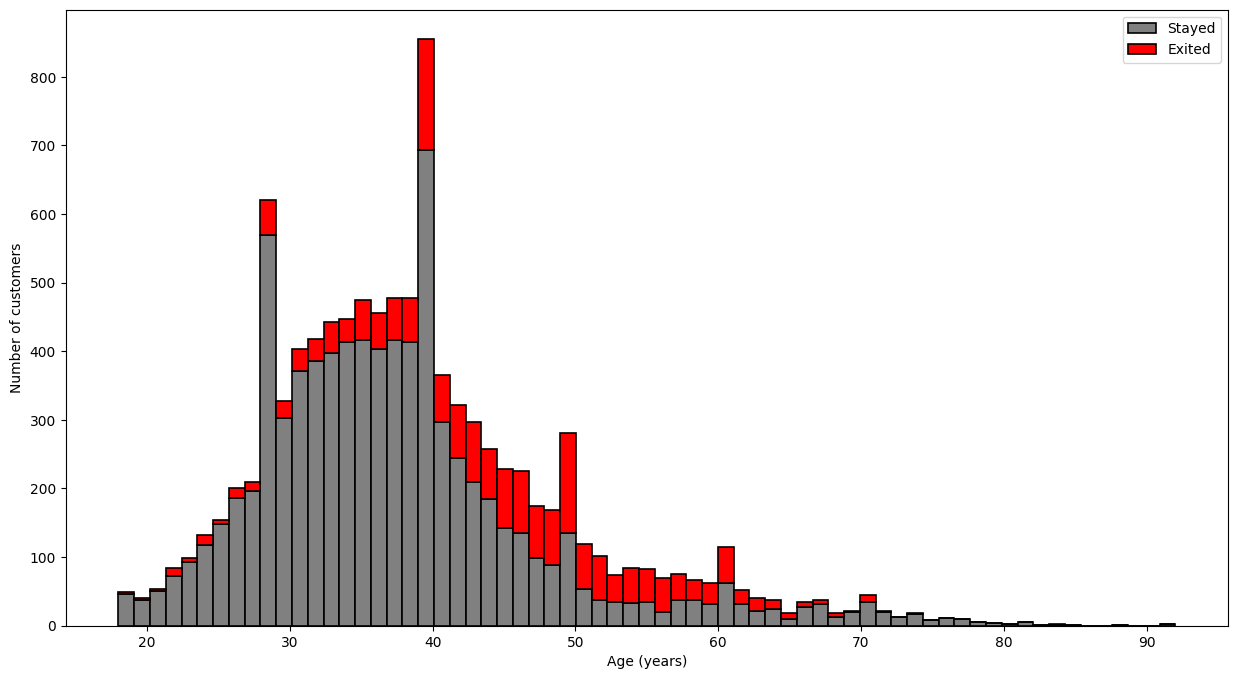

In [30]:
#Stacked histogram: Age
figure = plt.figure(figsize=(15,8))
plt.hist([
        dataset[(dataset.Exited==0)]['Age'],
        dataset[(dataset.Exited==1)]['Age']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
plt.xlabel('Age (years)')
plt.ylabel('Number of customers')
plt.legend()

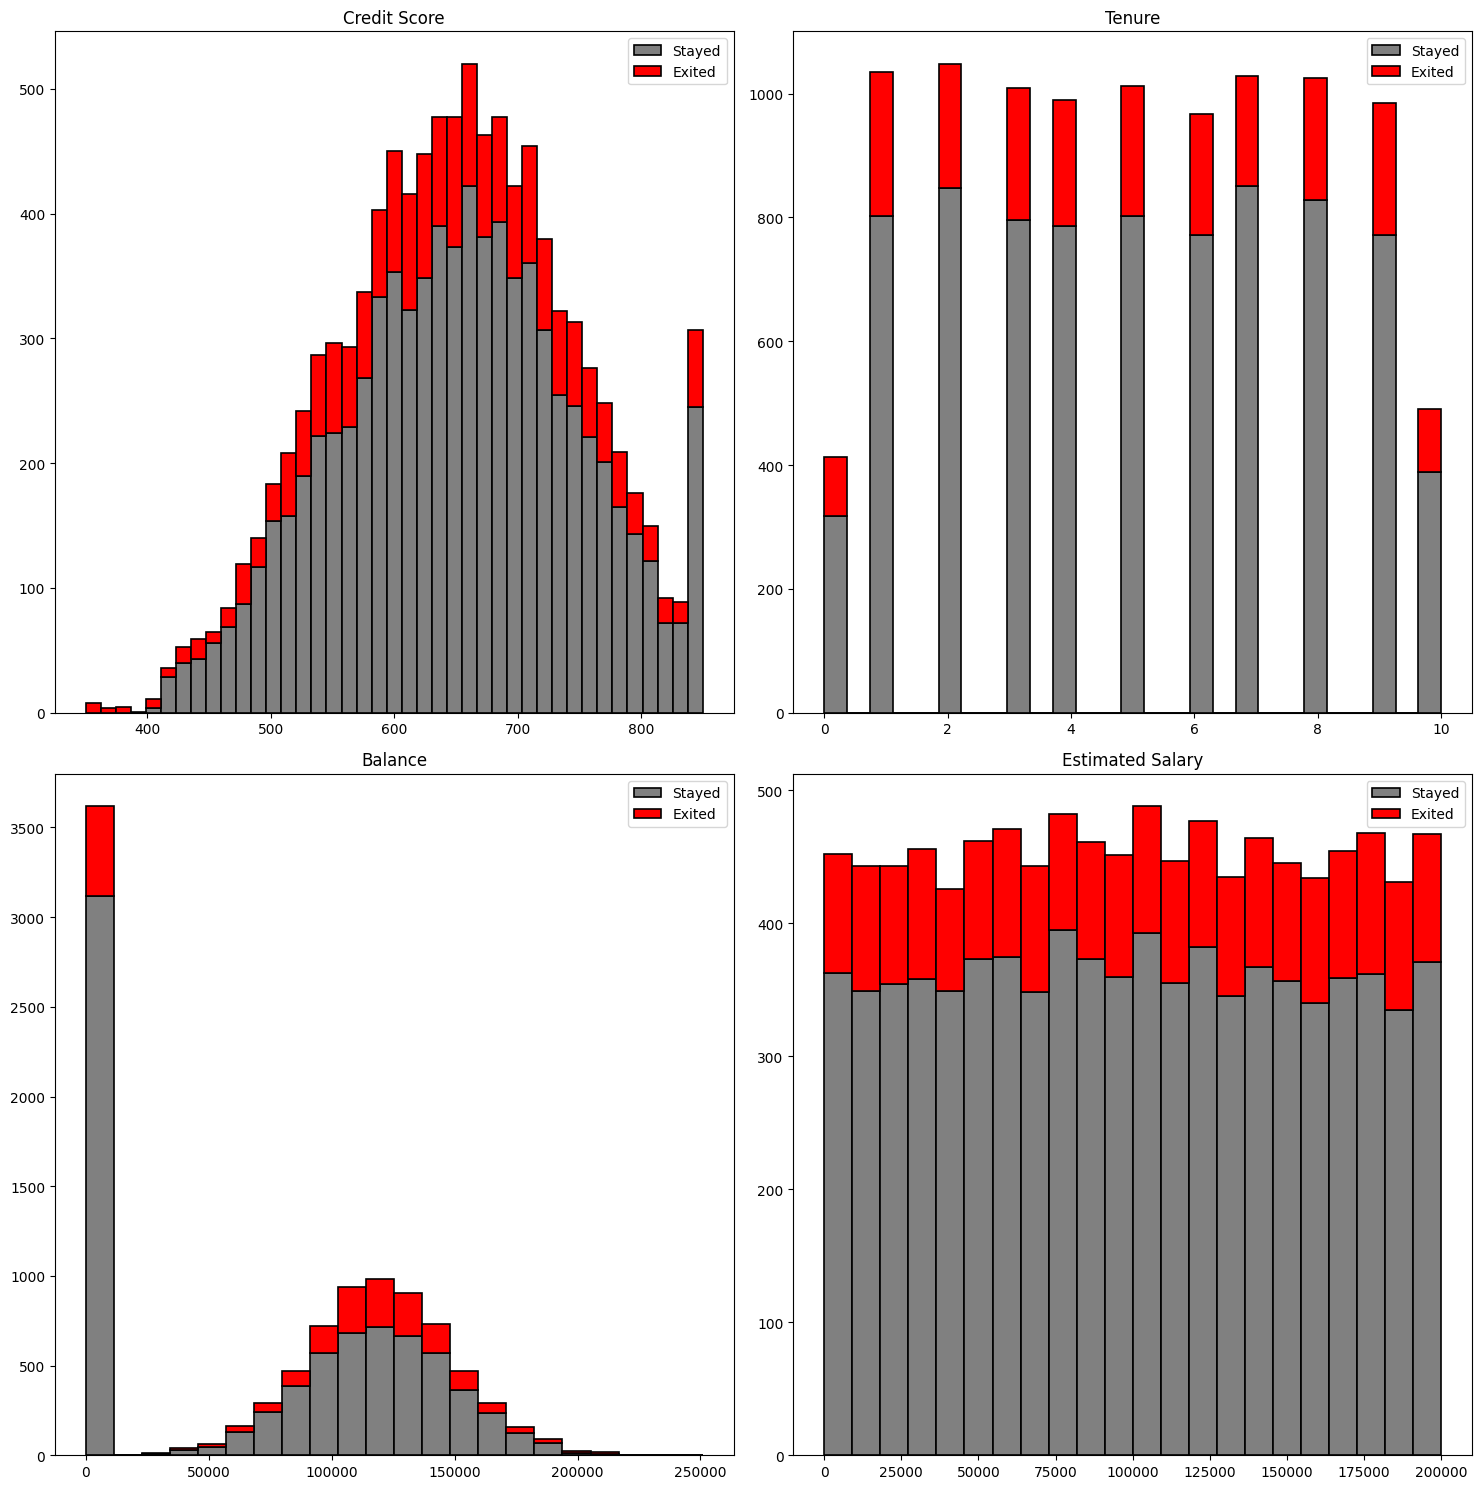

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15,15))
fig.subplots_adjust(left=0.2, wspace=0.6)
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.hist([
        dataset[(dataset.Exited==0)]['CreditScore'],
        dataset[(dataset.Exited==1)]['CreditScore']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
ax0.legend()
ax0.set_title('Credit Score')

ax1.hist([
        dataset[(dataset.Exited==0)]['Tenure'],
        dataset[(dataset.Exited==1)]['Tenure']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
ax1.legend()
ax1.set_title('Tenure')

ax2.hist([
        dataset[(dataset.Exited==0)]['Balance'],
        dataset[(dataset.Exited==1)]['Balance']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
ax2.legend()
ax2.set_title('Balance')

ax3.hist([
        dataset[(dataset.Exited==0)]['EstimatedSalary'],
        dataset[(dataset.Exited==1)]['EstimatedSalary']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
ax3.legend()
ax3.set_title('Estimated Salary')

fig.tight_layout()
plt.show()

From the tables and plots above, we can have some insights:

1. As for gender, women are lower in number than the men, but have a higher rate to close the account.
2. There is a higher rate of exited clients in Germany (32%, which is about 2x higher), and lower in Spain and France (around 16% each).
3. On age, customer bellow 40 and above 65 years old have a tendency to keep their account.
4. Has or not credit card does not impact on the decision to stay in the bank (both groups has 20% of exited customers)
5. Non active members tend to discontinue their services with a bank compared with the active clients (27% vs 14%). 
6. The dataset has 96% of clients  with 1 or 2 product, and customers with 1 product only have a higher rate to to close the account than those with 2 products (around 3x higher).
7. Estimated Salary does not seem to affect the churn rate

## 2. Predictive Models

### Separating Dataset into X and y subsets

In this project we will test the following models and choose the best one based on the accuracy, balanced accuracy, and Exited Recall.

Models to be tested:
* Logistic Regresstion (Package: Sklearn)
* Multi Layers Perceptron - MLP (Package: Sklearn)
* XGBoost (Package: XGBoost)
* XGB: Gradient Boosting Classifier (Package: Sklearn)
* Light GBM (Package: LightGBM)


As we have __imbalanced dataset__, we will test all the models defined above using two different strategies:
1. Complete training set (80% of the dataset)
2. Balanced training set, where we randomly select from the complete tranning set the same number of Stayed and Exited customers.





### 2.1 One-Hot encoding Categorical Attributes

In [32]:
# One-Hot encoding our categorical attributes
list_cat = ['Geography', 'Gender']
dataset = pd.get_dummies(dataset, columns = list_cat, prefix = list_cat)
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,...,Exited,Exited_str,HasCrCard_str,IsActiveMember_str,NumOfProducts_str,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1,15634602,Hargrave,619,42,2,0.00,1,1,1,...,1,Exited,Has Credit Card,Is Active Member,1,True,False,False,True,False
1,2,15647311,Hill,608,41,1,83807.86,1,0,1,...,0,Stayed,Does not have Credit Card,Is Active Member,1,False,False,True,True,False
2,3,15619304,Onio,502,42,8,159660.80,3,1,0,...,1,Exited,Has Credit Card,Is Not ActiveMember,3,True,False,False,True,False
3,4,15701354,Boni,699,39,1,0.00,2,0,0,...,0,Stayed,Does not have Credit Card,Is Not ActiveMember,2,True,False,False,True,False
4,5,15737888,Mitchell,850,43,2,125510.82,1,1,1,...,0,Stayed,Has Credit Card,Is Active Member,1,False,False,True,True,False


In [33]:
dataset = dataset.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited_str','HasCrCard_str', 'IsActiveMember_str','NumOfProducts_str'], axis = 1)

In [34]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_France   10000 non-null  bool   
 10  Geography_Germany  10000 non-null  bool   
 11  Geography_Spain    10000 non-null  bool   
 12  Gender_Female      10000 non-null  bool   
 13  Gender_Male        10000 non-null  bool   
dtypes: bool(5), float64(2), int64(7)
memory usage: 752.1 KB


In [35]:
features = list(dataset.drop('Exited', axis = 1))
target = 'Exited'

### 2.2 Splitting the dataset into the Training set and Test set

Now, let's split the data intro train and test sets (80% and 20%, respectively).

In [36]:
train, test = train_test_split(dataset, test_size = 0.2, random_state = 1)

print('Number of clients in the dataset: {}'.format(len(dataset)))
print('Number of clients in the train set: {}'.format(len(train)))
print('Number of clients in the test set: {}'.format(len(test)))

Number of clients in the dataset: 10000
Number of clients in the train set: 8000
Number of clients in the test set: 2000


In [37]:
exited_train = len(train[train['Exited'] == 1]['Exited'])
exited_train_perc = round(exited_train/len(train)*100,1)

exited_test = len(test[test['Exited'] == 1]['Exited'])
exited_test_perc = round(exited_test/len(test)*100,1)

print('Complete Train set - Number of clients that have exited the program: {} ({}%)'.format(exited_train, exited_train_perc))
print('Test set - Number of clients that haven\'t exited the program: {} ({}%)'.format(exited_test, exited_test_perc))

Complete Train set - Number of clients that have exited the program: 1622 (20.3%)
Test set - Number of clients that haven't exited the program: 415 (20.8%)


### 2.3 Feature Scaling

The data contain features in different order of magnitude. Tree based models can handle this kind of data without any normalization, but *logistic regression* and *neural networks* (MLP) require the normalization of the data for a better performance.

Here, I'm doing the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) normalization, and it is done according to the equation below:

$$
x^{,}_{i} = \frac{x_i - \bar{x}}{\sigma}
$$

where $x_i$ is the a data element, $\bar{x}$ is the mean of the feature, $\sigma$ is the standard deviation, and $x^{,}_{i}$ is the normalized element.

In [38]:
sc = StandardScaler()

# fit on training set
train[features] = sc.fit_transform(train[features])

# only transform on test set
test[features] = sc.transform(test[features])

### 2.4 Complete Trainning Set

#### 2.4.1 Logistic Regression (Sklearn) 

For the first prediction, let's use the [Sklearn Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) searching for the best parameters using the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function:

In [39]:
parameters = {'C': [0.01, 0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [50, 100, 150]}
LR = LogisticRegression(penalty = 'l2')
model_LR = GridSearchCV(LR, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(train[features], train[target])
pd.DataFrame(model_LR.cv_results_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020830,0.004215,0.003637,0.000353,0.01,50,newton-cg,"{'C': 0.01, 'max_iter': 50, 'solver': 'newton-...",0.813750,0.818750,0.807500,0.806250,0.810000,0.811250,0.004541,25
1,0.015490,0.001983,0.003198,0.000656,0.01,50,lbfgs,"{'C': 0.01, 'max_iter': 50, 'solver': 'lbfgs'}",0.813750,0.818750,0.807500,0.806250,0.810000,0.811250,0.004541,25
2,0.017004,0.003042,0.003052,0.000558,0.01,50,liblinear,"{'C': 0.01, 'max_iter': 50, 'solver': 'libline...",0.813750,0.820625,0.806875,0.804375,0.808750,0.810875,0.005764,58
3,0.036000,0.007622,0.002209,0.000400,0.01,50,sag,"{'C': 0.01, 'max_iter': 50, 'solver': 'sag'}",0.813750,0.818750,0.807500,0.806250,0.810000,0.811250,0.004541,25
4,0.039996,0.007995,0.003441,0.000367,0.01,50,saga,"{'C': 0.01, 'max_iter': 50, 'solver': 'saga'}",0.813750,0.818750,0.807500,0.806250,0.810000,0.811250,0.004541,25
5,0.020947,0.004670,0.002961,0.000602,0.01,100,newton-cg,"{'C': 0.01, 'max_iter': 100, 'solver': 'newton...",0.813750,0.818750,0.807500,0.806250,0.810000,0.811250,0.004541,25
6,0.010602,0.001576,0.002071,0.000484,0.01,100,lbfgs,"{'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs'}",0.813750,0.818750,0.807500,0.806250,0.810000,0.811250,0.004541,25
7,0.010377,0.000506,0.002451,0.000455,0.01,100,liblinear,"{'C': 0.01, 'max_iter': 100, 'solver': 'liblin...",0.813750,0.820625,0.806875,0.804375,0.808750,0.810875,0.005764,58
8,0.031169,0.004327,0.002515,0.000577,0.01,100,sag,"{'C': 0.01, 'max_iter': 100, 'solver': 'sag'}",0.813750,0.818750,0.807500,0.806250,0.810000,0.811250,0.004541,25
9,0.042139,0.010877,0.002710,0.000423,0.01,100,saga,"{'C': 0.01, 'max_iter': 100, 'solver': 'saga'}",0.813750,0.818750,0.807500,0.806250,0.810000,0.811250,0.004541,25


In [47]:
print(model_LR.best_params_)

{'C': 0.1, 'max_iter': 50, 'solver': 'newton-cg'}


Now that we know the "best" parameters for the model, let's do a *Recursive Feature Elimination* to check the feature importance.

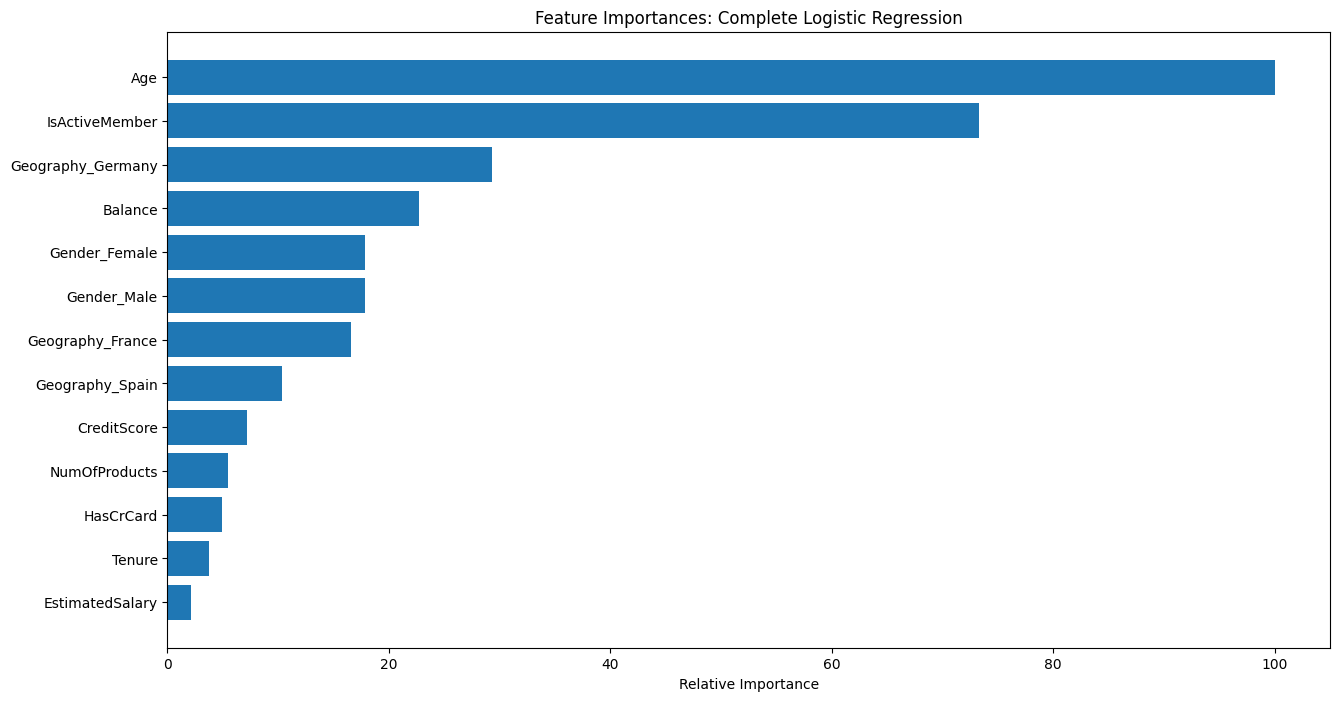

In [48]:

model = LogisticRegression(**model_LR.best_params_)
model.fit(train[features], train[target])

importances = abs(model.coef_[0])
importances = 100.0 * (importances / importances.max())
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Complete Logistic Regression')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Now, let's compute the predictions for the best set of parameters:

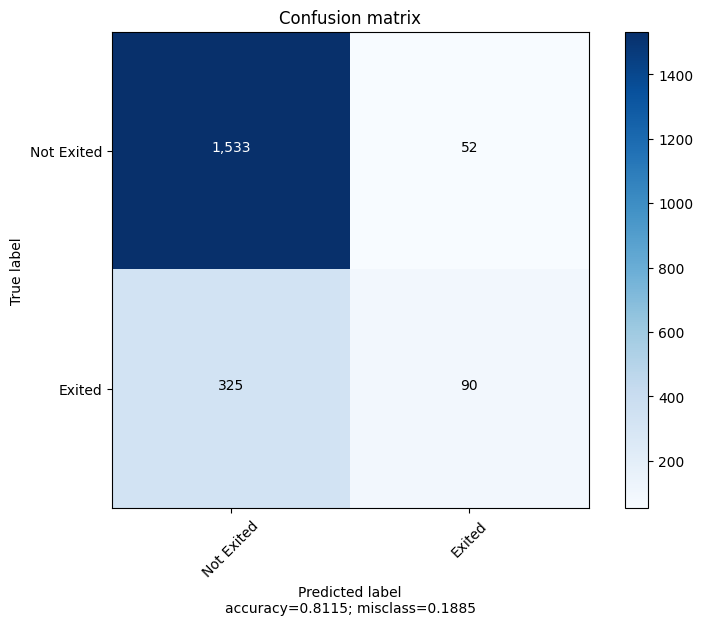

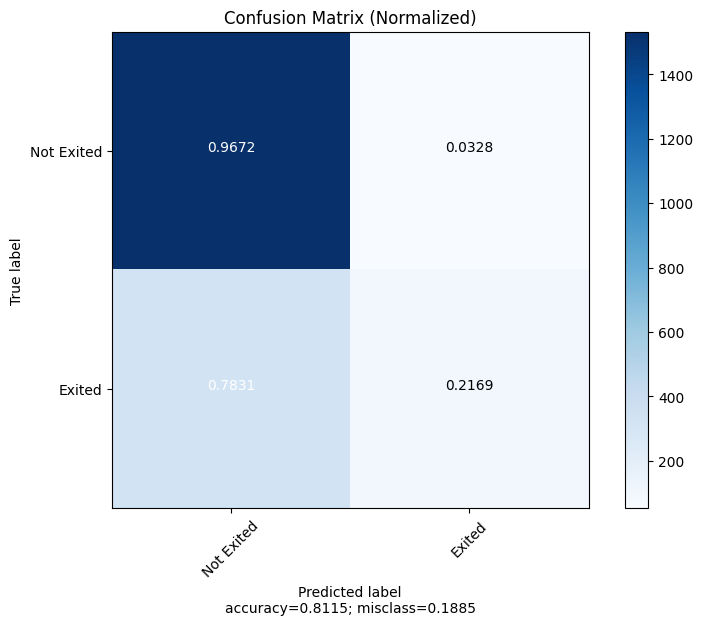

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.8115,0.59203,0.777611,0.825081,0.967192,0.890502,0.633803,0.216867,0.32316


In [49]:
pred = model_LR.predict(test[features])
predp = model_LR.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

table_of_models = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Logistic Regression')
table_of_models

#### 2.4.2 MLP: Multi Layers Perceptron

Now, let's enter in the `Neural Networks` domain, by doing predictions using the [Sklear Multi-Layer Perceptron (MLP) Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier).

In [51]:
s = len(features)
parameters = {'hidden_layer_sizes': [(s,),
                                     (s,)*2,
                                     (s,)*4,
                                     (s,)*6],
              'solver': ['lbfgs', 'adam'],
              'alpha': [0, 0.01, 0.1, 1, 10]}
MLP = MLPClassifier()
model_MLP = GridSearchCV(MLP, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(train[features], train[target])
pd.DataFrame(model_MLP.cv_results_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.264078,0.067885,0.005423,0.001922,0.00,"(13,)",lbfgs,"{'alpha': 0, 'hidden_layer_sizes': (13,), 'sol...",0.870000,0.865000,0.845000,0.858125,0.851875,0.858000,0.008939,5
1,3.789904,0.269036,0.003999,0.000384,0.00,"(13,)",adam,"{'alpha': 0, 'hidden_layer_sizes': (13,), 'sol...",0.858750,0.865625,0.841250,0.853125,0.850000,0.853750,0.008206,15
2,1.493847,0.098864,0.004161,0.001036,0.00,"(13, 13)",lbfgs,"{'alpha': 0, 'hidden_layer_sizes': (13, 13), '...",0.850625,0.848125,0.836875,0.860625,0.845625,0.848375,0.007681,29
3,4.910753,0.140751,0.003486,0.000668,0.00,"(13, 13)",adam,"{'alpha': 0, 'hidden_layer_sizes': (13, 13), '...",0.853125,0.853125,0.851875,0.859375,0.858750,0.855250,0.003152,12
4,2.497995,0.230261,0.004746,0.001464,0.00,"(13, 13, 13, 13)",lbfgs,"{'alpha': 0, 'hidden_layer_sizes': (13, 13, 13...",0.851250,0.843750,0.843750,0.845625,0.859375,0.848750,0.005982,28
5,7.261249,0.324735,0.003733,0.000390,0.00,"(13, 13, 13, 13)",adam,"{'alpha': 0, 'hidden_layer_sizes': (13, 13, 13...",0.847500,0.840625,0.838750,0.863750,0.843750,0.846875,0.008944,33
6,3.979176,0.249314,0.004553,0.000727,0.00,"(13, 13, 13, 13, 13, 13)",lbfgs,"{'alpha': 0, 'hidden_layer_sizes': (13, 13, 13...",0.850000,0.853125,0.842500,0.857500,0.845625,0.849750,0.005312,23
7,8.910849,0.420219,0.004245,0.000671,0.00,"(13, 13, 13, 13, 13, 13)",adam,"{'alpha': 0, 'hidden_layer_sizes': (13, 13, 13...",0.850000,0.848125,0.831875,0.861250,0.835625,0.845375,0.010567,35
8,0.792061,0.083264,0.003721,0.000677,0.01,"(13,)",lbfgs,"{'alpha': 0.01, 'hidden_layer_sizes': (13,), '...",0.863125,0.854375,0.848750,0.851875,0.856875,0.855000,0.004873,14
9,3.131437,0.377151,0.003097,0.000716,0.01,"(13,)",adam,"{'alpha': 0.01, 'hidden_layer_sizes': (13,), '...",0.860000,0.868125,0.845000,0.857500,0.853750,0.856875,0.007583,8


In [52]:
print(model_MLP.best_params_)

{'alpha': 1, 'hidden_layer_sizes': (13, 13, 13, 13, 13, 13), 'solver': 'adam'}


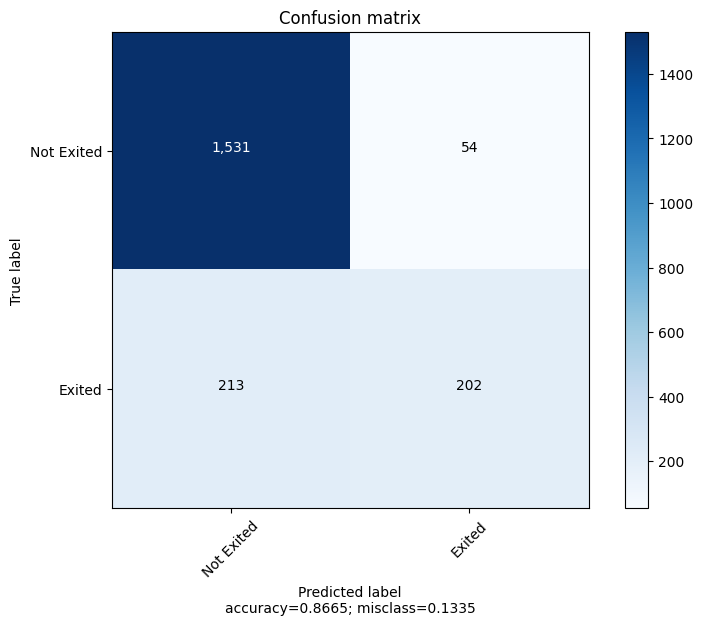

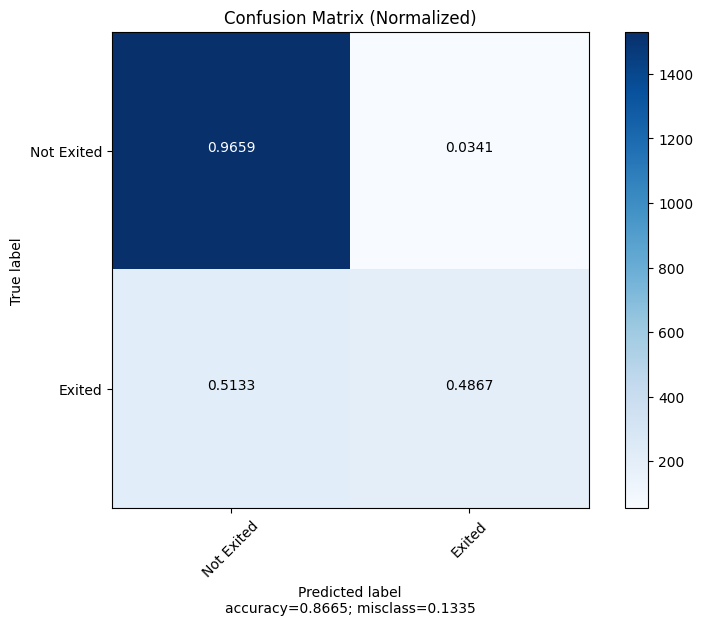

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Multi-Layer Perceptron (MLP),no,0.8665,0.726339,0.87373,0.877867,0.965931,0.919796,0.789062,0.486747,0.602086


In [53]:
pred = model_MLP.predict(test[features])
predp = model_MLP.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Multi-Layer Perceptron (MLP)')
temp

#### 2.4.3 Gradient Boosting Classifier (Sklearn)

Now, let's use the [Sklearn Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) algorithm for the predictions.

In [55]:
parameters = {'max_depth': [2, 3, 4, 6, 10, 15],
              'n_estimators': [50, 100, 300, 500]}
GB = GBSklearn()
model_GB = GridSearchCV(GB, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(train[features], train[target])
pd.DataFrame(model_GB.cv_results_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.435437,0.026424,0.004613,0.000657,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.870625,0.855625,0.849375,0.855625,0.852500,0.856750,0.007314,13
1,0.895085,0.007863,0.005507,0.000621,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.870625,0.858125,0.855000,0.862500,0.859375,0.861125,0.005324,5
2,2.547862,0.064928,0.007295,0.000482,2,300,"{'max_depth': 2, 'n_estimators': 300}",0.868750,0.863750,0.856875,0.861250,0.860625,0.862250,0.003925,2
3,4.202938,0.155797,0.010140,0.000835,2,500,"{'max_depth': 2, 'n_estimators': 500}",0.868750,0.861250,0.856875,0.858125,0.861250,0.861250,0.004127,3
4,0.555931,0.049954,0.003887,0.000516,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.871875,0.861875,0.854375,0.862500,0.854375,0.861000,0.006466,7
5,1.163286,0.057723,0.004960,0.000712,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.875000,0.864375,0.855625,0.865625,0.861250,0.864375,0.006337,1
6,3.416552,0.174699,0.009500,0.000034,3,300,"{'max_depth': 3, 'n_estimators': 300}",0.871250,0.861250,0.854375,0.856250,0.861250,0.860875,0.005858,8
7,5.754080,0.139646,0.013460,0.000494,3,500,"{'max_depth': 3, 'n_estimators': 500}",0.865000,0.860625,0.853125,0.855625,0.864375,0.859750,0.004704,12
8,0.759049,0.021252,0.004601,0.000491,4,50,"{'max_depth': 4, 'n_estimators': 50}",0.870000,0.863750,0.851875,0.863750,0.856250,0.861125,0.006354,5
9,1.527909,0.047586,0.006647,0.000664,4,100,"{'max_depth': 4, 'n_estimators': 100}",0.870000,0.864375,0.853125,0.861875,0.856875,0.861250,0.005863,3


In [56]:
print(model_GB.best_params_)

{'max_depth': 3, 'n_estimators': 100}


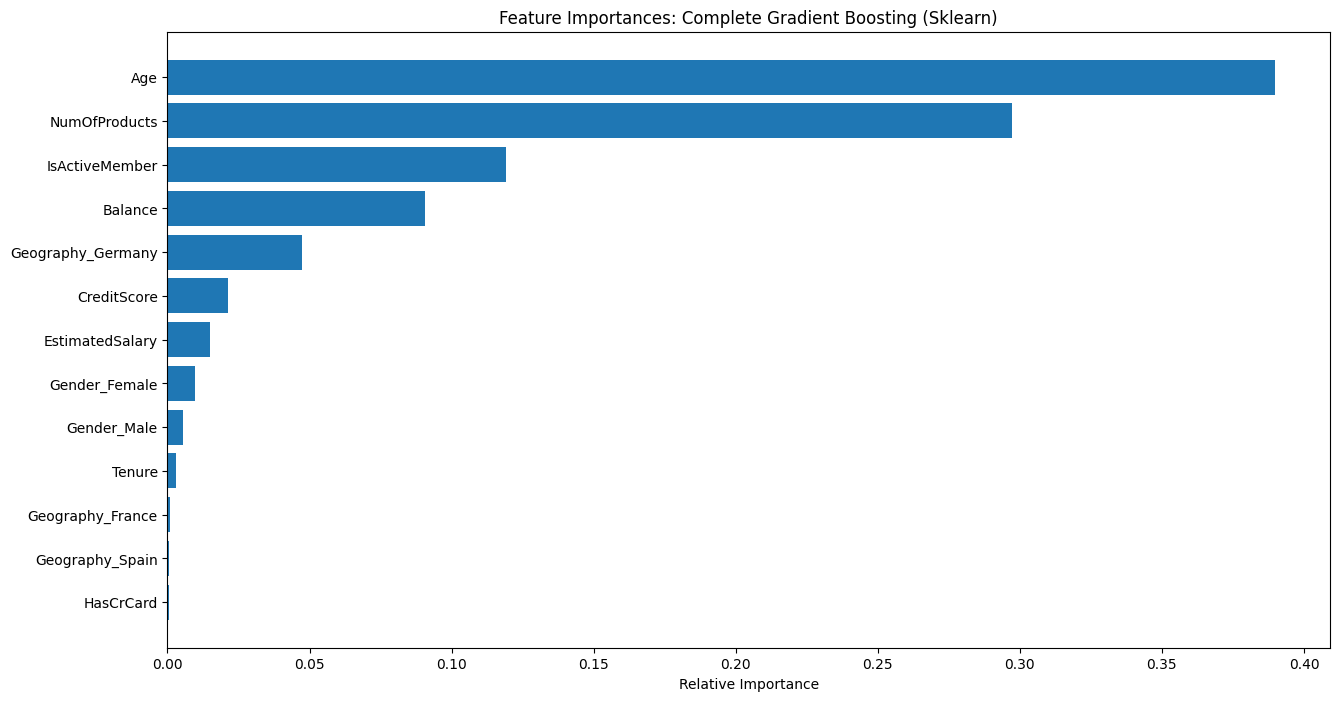

In [57]:
model = GBSklearn(**model_GB.best_params_)
model.fit(train[features], train[target])

importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Complete Gradient Boosting (Sklearn)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

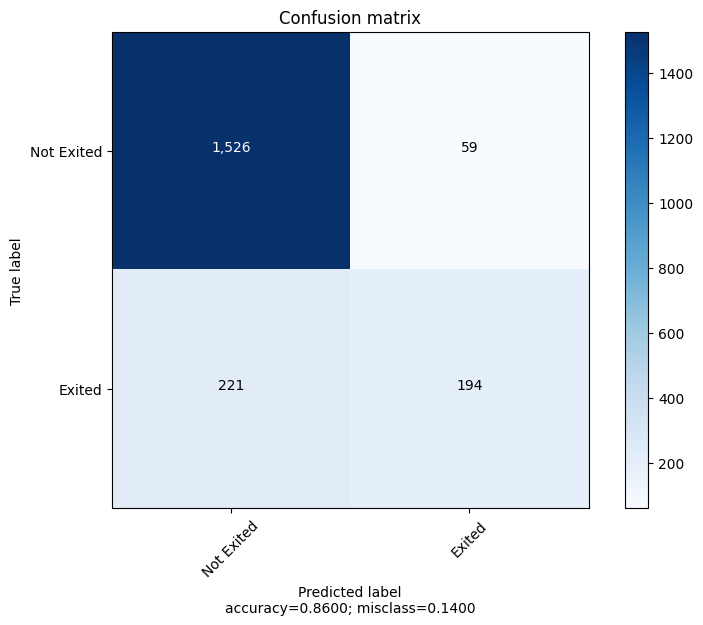

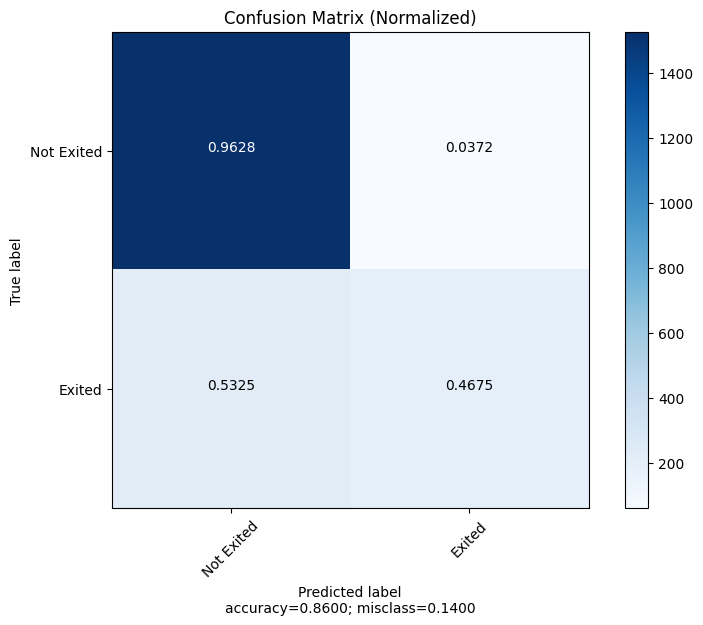

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Gradient Boosting (Sklearn),no,0.86,0.715123,0.878346,0.873497,0.962776,0.915966,0.766798,0.46747,0.580838


In [58]:
pred = model_GB.predict(test[features])
predp = model_GB.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting (Sklearn)')
temp

#### 2.4.4 Extreme Gradient Boosting (XGBoost)

Let's get out of the `Scikit-learn` for now and try the package [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html).

In [60]:
model_XGB = XGB(max_depth = 6,
            learning_rate = .1,
            n_estimators = 100,
            reg_lambda = 0.5,
            reg_alpha = 0,
            verbosity = 1,
            n_jobs = -1,
            tree_method = 'gpu_exact').fit(train[features], train[target])

pred = model_XGB.predict(test[features])
predp = model_XGB.predict_proba(test[features])[:,1]

importances = model_XGB.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Complete Extreme Gradient Boosting (XGBoost)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

XGBoostError: Invalid Input: 'gpu_exact', valid values are: {'approx', 'auto', 'exact', 'gpu_hist', 'hist'}

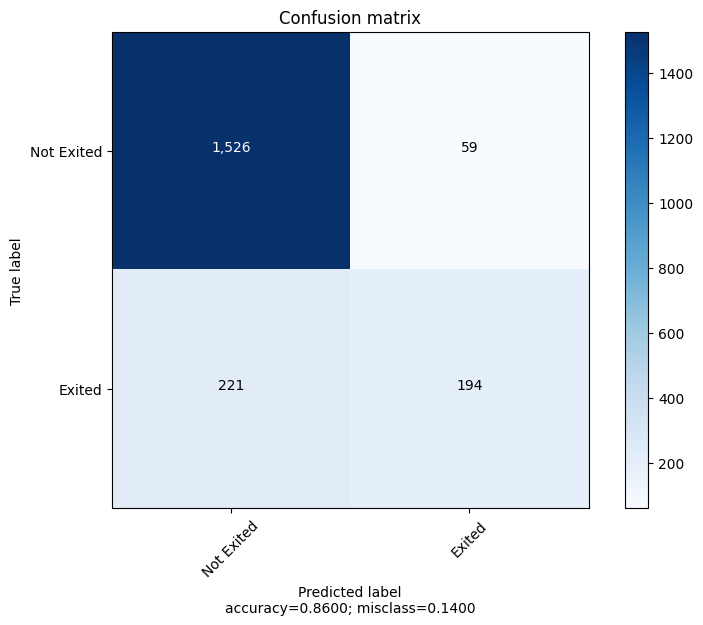

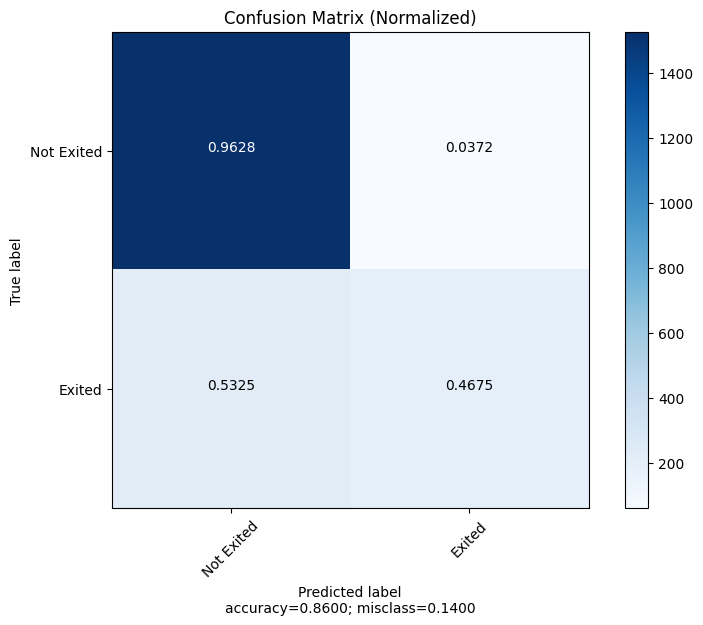

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Gradient Boosting (XGBoost),no,0.86,0.715123,0.878346,0.873497,0.962776,0.915966,0.766798,0.46747,0.580838


In [61]:
cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting (XGBoost)')
temp

In [63]:
train_data = lgb.Dataset(train[features],
                         label = train[target],
                         feature_name = features)
test_data = lgb.Dataset(test[features + [target]],
                              reference = train_data)

In [64]:
param = {'num_leaves': 21,
         'num_trees': 100,
         # 'max_depth': 20,
         'objective': 'binary',
         # 'boosting': 'dart',
         'lambda_l1': 1,
         'lambda_l2': 1,
         'learning_rate': 0.1,
         'metric': ['binary_logloss', 'binary_error'],
         'seed': 1}

num_round = 10
model_LGB = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[LightGBM] [Info] Number of positive: 1622, number of negative: 6378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202750 -> initscore=-1.369195
[LightGBM] [Info] Start training from score -1.369195


<Axes: title={'center': 'Feature Importances: Complete Light Gradient Boosting Machine (LightGBM)'}, xlabel='Feature importance'>

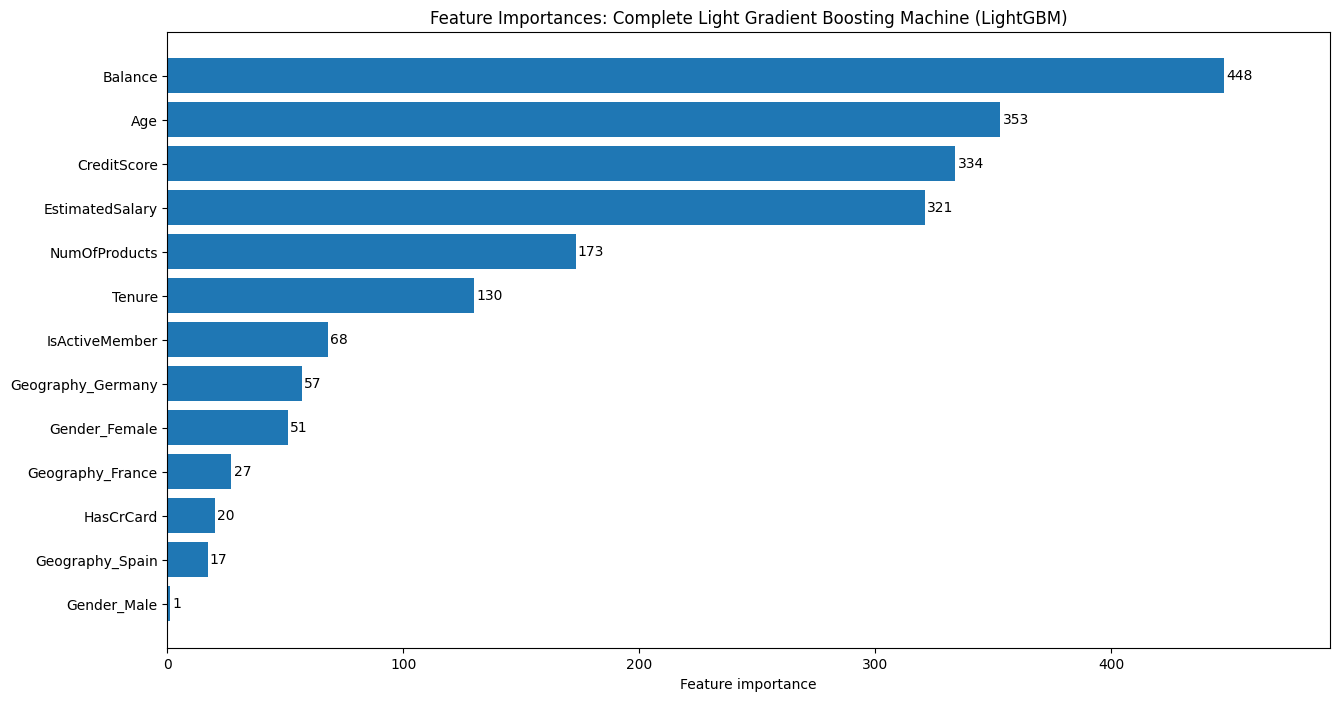

In [65]:
predp = model_LGB.predict(test[features])
pred = predp > 0.5

lgb.plot_importance(model_LGB,
                    figsize = (15,8),
                    height = 0.8,
                    title = 'Feature Importances: Complete Light Gradient Boosting Machine (LightGBM)',
                    ylabel = None,
                    grid = False)

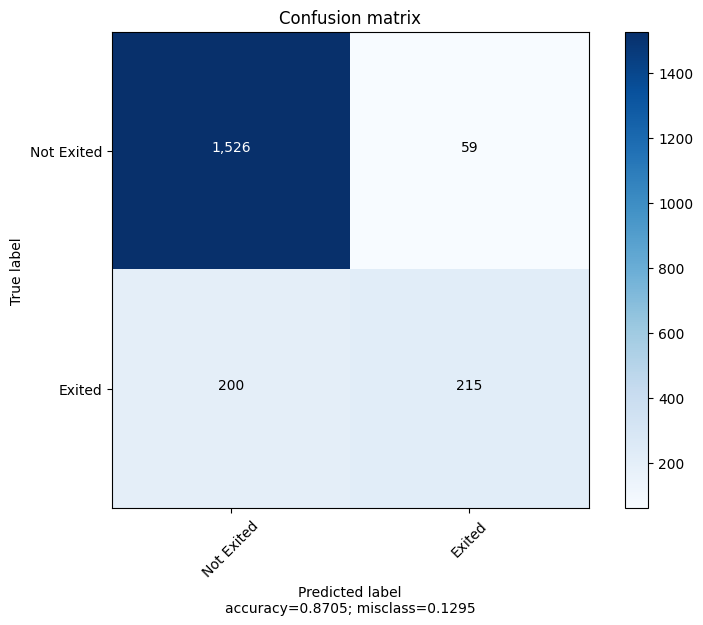

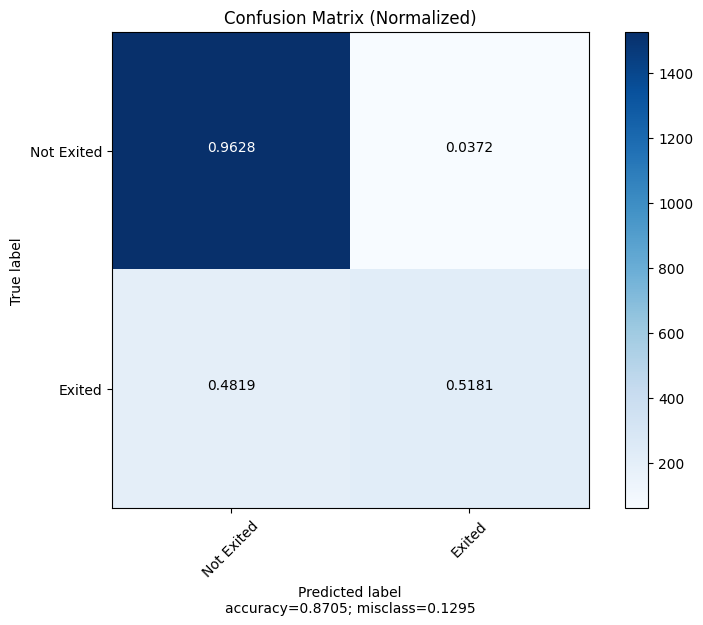

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Gradient Boosting (LightGBM),no,0.8705,0.740424,0.878414,0.884125,0.962776,0.921776,0.784672,0.518072,0.624093


In [66]:
cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting (LightGBM)')
temp

## 2.5 Balanced Tranning Set

The data provided is imbalanced, where `80%` of the clients are not exited ones (labeled as `0`), and `20%` are exited ones (labeled as `1`). We can reach `80%` accuracy by only selecting a model that predict all the clients as `0`. However, checking at the balanced accuracy, which is the average of the recall of each class.

One way to get around with this issue is to randomly remove data from the larger class until it matches the number of the smaller class, so `50%` is `0` and `50%` is `1`. We do this balance only on the train set, so the trained model is not biased, but the test data is kept untouched.

The *resample_data* function will balance the data for us.

In [68]:
def resample_data(data, target):
    data_1 = data[data[target] == 1]
    data_0 = data[data[target] == 0]
    percentage = len(data_1)/len(data_0)
    temp = data_0.sample(frac = percentage, random_state = 1)

    data_new = data_1.append(temp)
    data_new.sort_index(inplace = True)
    return data_new

In [69]:
trainB = resample_data(train, target = target)
print('Number of clients in the dataset is : {}'.format(len(dataset)))
print('Number of clients in the balanced train set is : {}'.format(len(trainB)))
print('Number of clients in the test set is : {}'.format(len(test)))

AttributeError: 'DataFrame' object has no attribute 'append'

In [70]:
exited_trainB = len(trainB[trainB['Exited'] == 1]['Exited'])
exited_trainB_perc = round(exited_trainB/len(trainB)*100,1)

exited_test = len(test[test['Exited'] == 1]['Exited'])
exited_test_perc = round(exited_test/len(test)*100,1)

print('Balanced Train set - Number of clients that have exited the program: {} ({}%)'.format(exited_trainB, exited_trainB_perc))
print('Test set - Number of clients that haven\'t exited the program: {} ({}%)'.format(exited_test, exited_test_perc))

NameError: name 'trainB' is not defined

#### 2.5.1 Logistic Regresstion

In [71]:
parameters = {'C': [0.01, 0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [50, 100, 150]}
LR = LogisticRegression(penalty = 'l2')
model_LR = GridSearchCV(LR, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(trainB[features], trainB[target])
pd.DataFrame(model_LR.cv_results_)

NameError: name 'trainB' is not defined

In [72]:
print(model_LR.best_params_)

{'C': 0.1, 'max_iter': 50, 'solver': 'newton-cg'}


In [73]:
model = LogisticRegression(**model_LR.best_params_)
model.fit(trainB[features], trainB[target])

importances = abs(model.coef_[0])
importances = 100.0 * (importances / importances.max())
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Balanced Logistic Regression')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

NameError: name 'trainB' is not defined

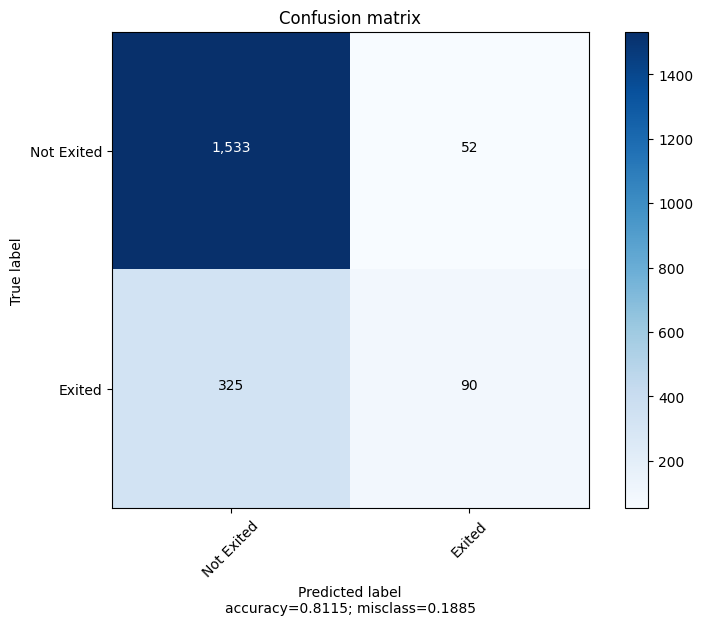

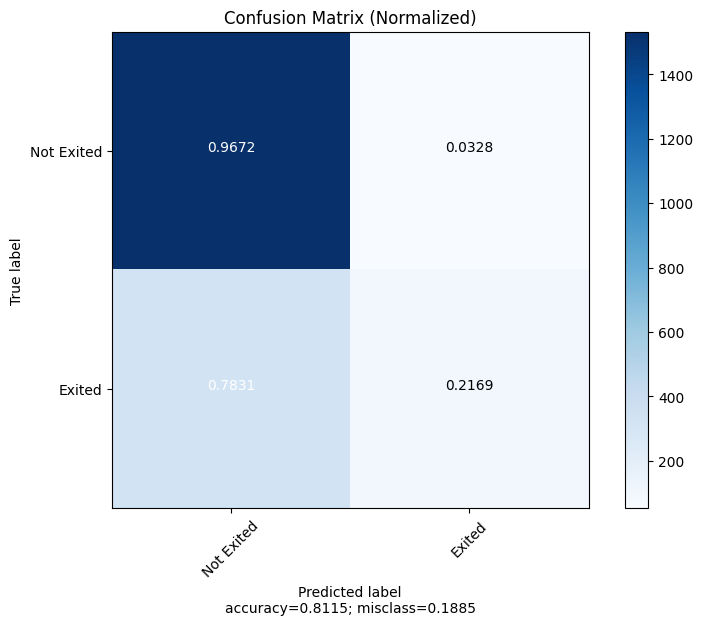

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,yes,0.8115,0.59203,0.777611,0.825081,0.967192,0.890502,0.633803,0.216867,0.32316


In [74]:
pred = model_LR.predict(test[features])
predp = model_LR.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Logistic Regression', balanced = 'yes')
temp

In [75]:
table_of_models = table_of_models.append(temp)
table_of_models

AttributeError: 'DataFrame' object has no attribute 'append'

#### 2.5.2 MLP: Multi Layers Perceptron

In [76]:
s = len(features)
parameters = {'hidden_layer_sizes': [(s,),
                                     (s,)*2,
                                     (s,)*4,
                                     (s,)*6],
              'solver': ['lbfgs', 'adam'],
              'alpha': [0, 0.01, 0.1, 1, 10]}
MLP = MLPClassifier()
model_MLP = GridSearchCV(MLP, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(trainB[features], trainB[target])
pd.DataFrame(model_MLP.cv_results_)

NameError: name 'trainB' is not defined

In [77]:
print(model_MLP.best_params_)

{'alpha': 1, 'hidden_layer_sizes': (13, 13, 13, 13, 13, 13), 'solver': 'adam'}


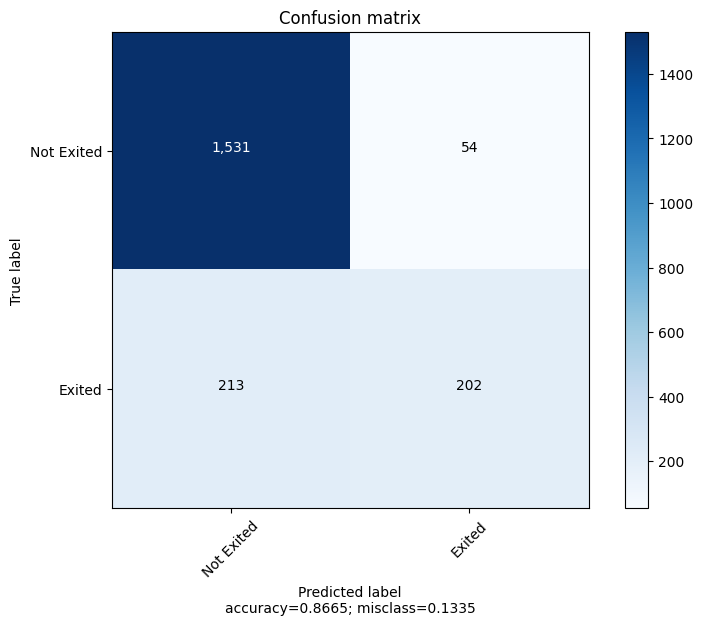

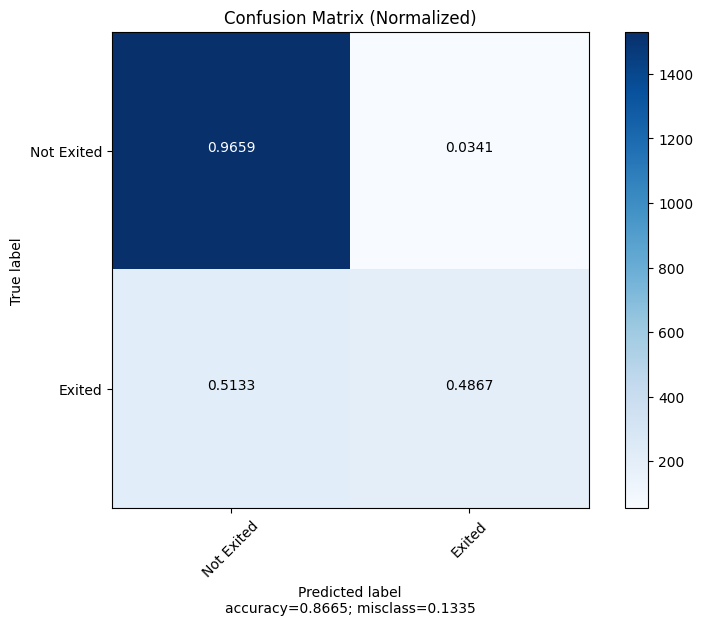

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Multi-Layer Perceptron (MLP),yes,0.8665,0.726339,0.87373,0.877867,0.965931,0.919796,0.789062,0.486747,0.602086


In [78]:
pred = model_MLP.predict(test[features])
predp = model_MLP.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Multi-Layer Perceptron (MLP)', balanced = 'yes')
temp

In [79]:
table_of_models = table_of_models.append(temp)
table_of_models

AttributeError: 'DataFrame' object has no attribute 'append'

#### 2.5.3 Gradient Boosting Classifier (Sklearn)

In [80]:
parameters = {'max_depth': [2, 3, 4, 6, 10, 15],
              'n_estimators': [50, 100, 300, 500]}
GB = GBSklearn()
model_GB = GridSearchCV(GB,
                        parameters,
                        cv = 5,
                        n_jobs = 10,
                        verbose = 1).fit(trainB[features], trainB[target])
pd.DataFrame(model_GB.cv_results_)

NameError: name 'trainB' is not defined

In [81]:
print(model_GB.best_params_)

{'max_depth': 3, 'n_estimators': 100}


In [82]:
model = GBSklearn(**model_GB.best_params_)
model.fit(trainB[features], trainB[target])

importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Balanced Gradient Boosting (Sklearn)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

NameError: name 'trainB' is not defined

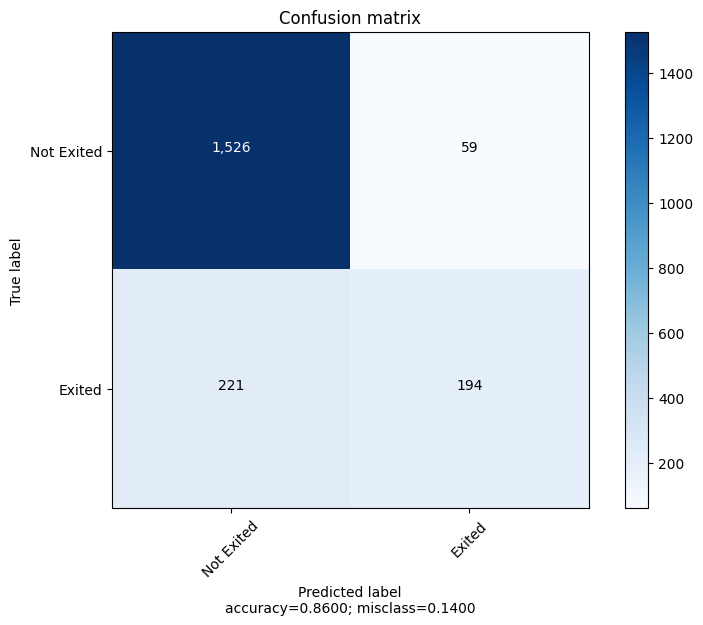

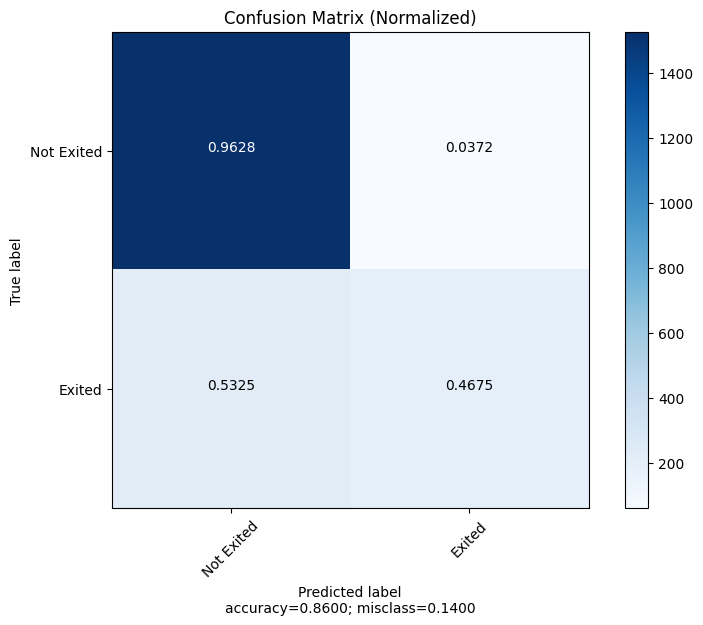

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Gradient Boosting (Sklearn),yes,0.86,0.715123,0.878346,0.873497,0.962776,0.915966,0.766798,0.46747,0.580838


In [83]:
pred = model_GB.predict(test[features])
predp = model_GB.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting (Sklearn)', balanced = 'yes')
temp

In [84]:
table_of_models = table_of_models.append(temp)
table_of_models

AttributeError: 'DataFrame' object has no attribute 'append'

#### 2.5.4 Extreme Gradient Boosting (XGBoost)

In [85]:
model_XGB = XGB(max_depth = 6,
            learning_rate = .1,
            n_estimators = 100,
            reg_lambda = 0.5,
            reg_alpha = 0,
            verbosity = 1,
            n_jobs = -1,
            tree_method = 'gpu_exact').fit(trainB[features], trainB[target])

pred = model_XGB.predict(test[features])
predp = model_XGB.predict_proba(test[features])[:,1]

importances = model_XGB.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Balanced Extreme Gradient Boosting (XGBoost)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

NameError: name 'trainB' is not defined

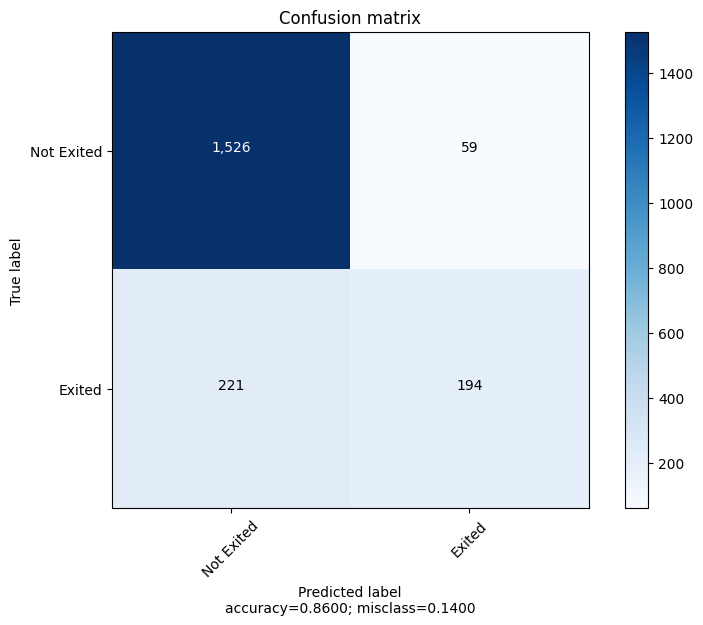

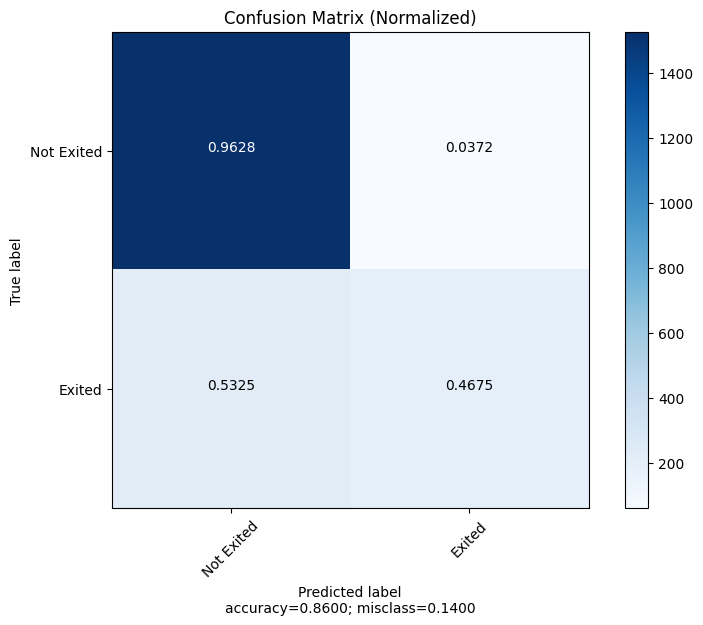

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Gradient Boosting (XGBoost),yes,0.86,0.715123,0.878346,0.873497,0.962776,0.915966,0.766798,0.46747,0.580838


In [86]:
cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting (XGBoost)', balanced = 'yes')
temp

In [87]:
table_of_models = table_of_models.append(temp)
table_of_models

AttributeError: 'DataFrame' object has no attribute 'append'

#### 2.5.5 Light Gradient Boosting Machine (LightGBM)

In [88]:
train_data = lgb.Dataset(trainB[features],
                         label = trainB[target],
                         feature_name = features)
test_data = lgb.Dataset(test[features + [target]],
                              reference = train_data)

NameError: name 'trainB' is not defined

In [89]:
param = {'num_leaves': 21,
         'num_trees': 100,
         # 'max_depth': 20,
         'objective': 'binary',
         # 'boosting': 'dart',
         'lambda_l1': 1,
         'lambda_l2': 1,
         'learning_rate': 0.1,
         'metric': ['binary_logloss', 'binary_error'],
         'seed': 1}

num_round = 10
model_LGB = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[LightGBM] [Info] Number of positive: 1622, number of negative: 6378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202750 -> initscore=-1.369195
[LightGBM] [Info] Start training from score -1.369195


<Axes: title={'center': 'Feature Importances: Balanced Light Gradient Boosting Machine (LightGBM)'}, xlabel='Feature importance'>

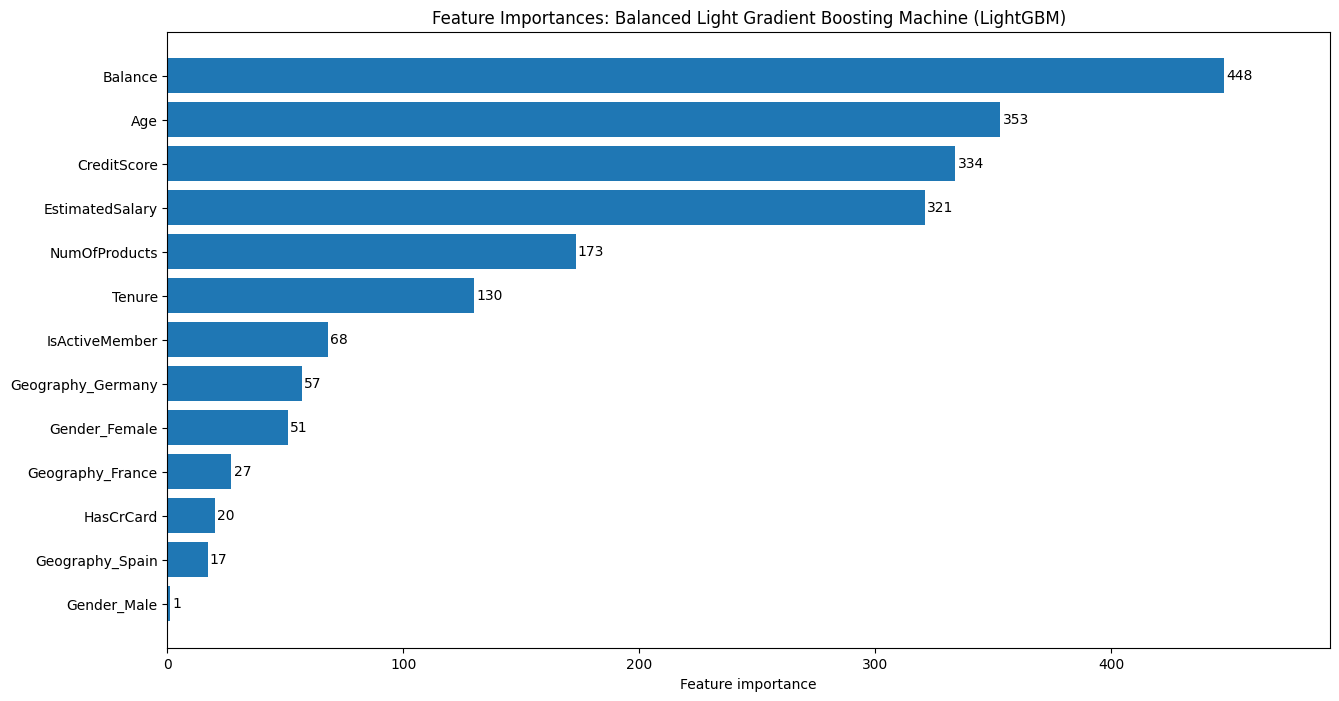

In [90]:
predp = model_LGB.predict(test[features])
pred = predp > 0.5

lgb.plot_importance(model_LGB,
                    figsize = (15,8),
                    height = 0.8,
                    title = 'Feature Importances: Balanced Light Gradient Boosting Machine (LightGBM)',
                    ylabel = None,
                    grid = False)

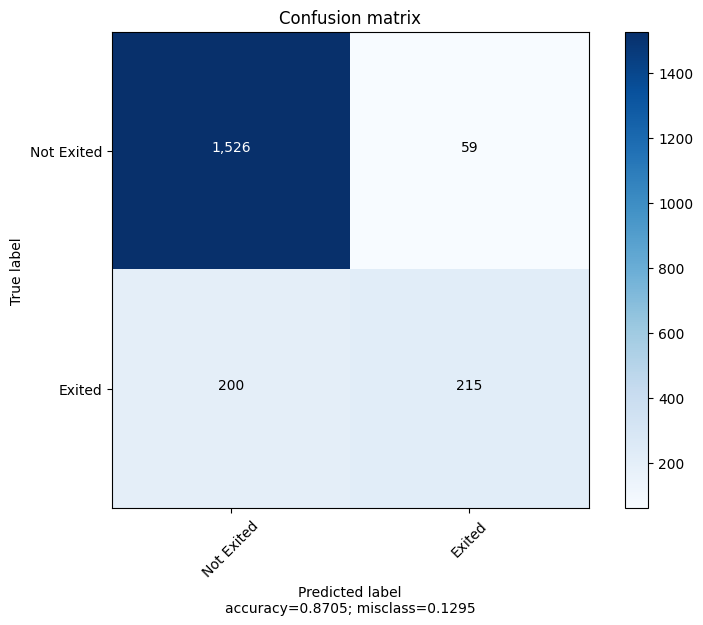

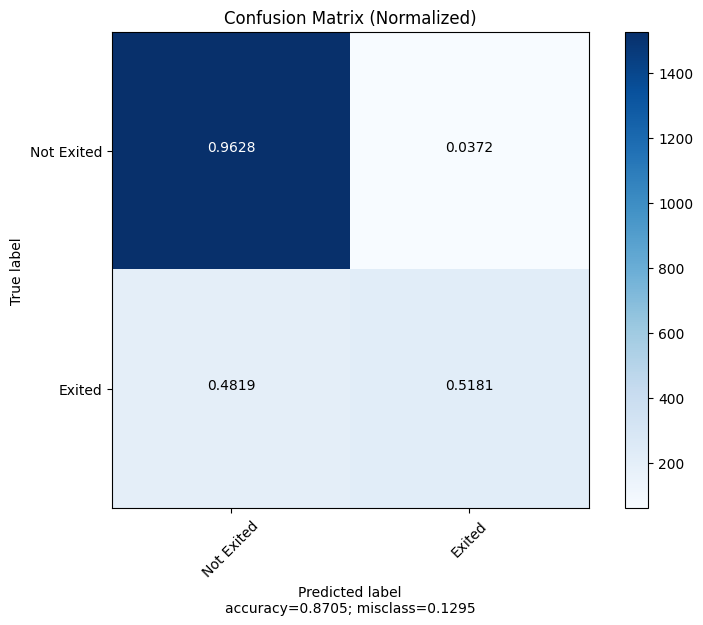

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Gradient Boosting (LightGBM),yes,0.8705,0.740424,0.878414,0.884125,0.962776,0.921776,0.784672,0.518072,0.624093


In [91]:
cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting (LightGBM)', balanced = 'yes')
temp

In [83]:
table_of_models.to_excel('table_of_models.xlsx', index = False)

# Conclusions

On this notebook, I went through the `bank custumer churn` data. My focus was to process the data for modelling, and try different algorithms to evaluate their performance.

The first step was to analize the features, try to understand them, and have some insights.

Later, I started to prepare the data for the modelling. First, I applied a one-hot-encoding over the cathegorical features. After, I splitted the data into the train and test sets, standardazing the features on each set. Then, the modelling was done in two parts, one with the complete train data, and another with a balanced train data. For each part I test the same models and algorithms:

1. Logistic Regression
2. Multi-Layer Perceptron
3. Gradient Boosting (Scikit-Learn)
4. Extreme Gradient Boosting (XGBoost)
5. Light Gradient Boosting Machine (LightGBM)

Initially, we tested the models performance. They all, when looking to the *pure accuracy* score behaved reasonably well. Only the *logistic regression* was one step behind. However, the data is imbalanced. `80%` of the data are clients that didn't exited (labeled as `0`). So, if we create a model that predicts `0` for all the clients, its accuracy will be of `80%`. A better score metric is the *balanced accuracy*, that weights the classes by occurence. For the balanced accuracy, the baseline, for a binary classification, is of `50%`. Looking at the balanced accuracy for all the predictions, the *logistic regression* did a poor job, with `59%` accuracy. The other models had a balanced accuracy from `72%` to `74%`, with the *lightGBM* being slightly better, when also looking at the *recall* of the exited clients (labaled as `1`).

Trying to improve the predictions for the exited clients (label `1`), I proposed to balance the train data, by simply ramdonly removing clients labeled as `0` until the number of exited and not exited were almost the same. When I did that, I was expecting that the *accuracy* and the *balanced accuracy* to have similar values for each model, and that was exactly what happened. For all the models, the balanced accuracy increased to up to `79%` (*LightGBM*), and showed that the tree based classifier models worked better.

By looking at the score metrics and speed performance, the model I would chose is the **Gradient Boosting Classifier** from the *LightGBM* package. But the *XGBoost* is close behind.

However, I still believe I can improve the accuracy by applying feature engineering on the data, as well trying other models, even doing an ensemble model over all the tested models.